In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [5]:
train=pd.read_csv('input/train.csv', index_col=0) #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [6]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum()
test.isnull().sum()

### outlier

### education

In [7]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [8]:
df = pd.concat([train, test])

df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [9]:
train['Priority'] = 0
train.loc[(train['education_num'] == 1)
          & ((train['occupation'] == 'Priv-house-serv') 
             | (train['occupation'] == 'Armed-Forces')), 'Priority'] = 1
train.loc[(train['education_num'] >=2) & (train['education_num'] <= 8)
          & ((train['occupation'] == 'Handlers-cleaners') | (train['occupation'] == 'Other-service')), 'Priority'] = 2
train.loc[(train['education_num'] >=9) & (train['education_num'] <= 10)
          & ((train['occupation'] == 'Transport-moving') 
             | (train['occupation'] == 'Adm-clerical')
             | (train['occupation'] == 'Machine-op-inspct')
             | (train['occupation'] == 'Farming-fishing')
             | (train['occupation'] == '?')
            )
          , 'Priority'] = 3
train.loc[(train['education_num'] >=11) & (train['education_num'] <= 12) & ((train['occupation'] == 'SalesCraft-repair') | (train['occupation'] == 'Prof-specialty')), 'Priority'] = 4
train.loc[(train['occupation'] == 'Protective-serv') | (train['occupation'] == 'Tech-support'), 'Priority'] = 5
train.loc[(train['education_num'] ==13) & ((train['occupation'] == 'Exec-managerial') | (train['occupation'] == 'Prof-specialty')), 'Priority'] = 6
train.loc[(train['education_num'] ==14), 'Priority'] = 7
train.loc[(train['education_num'] >=15), 'Priority'] = 8

In [16]:
test['Priority'] = 0
test.loc[(test['education_num'] == 1)
          & ((test['occupation'] == 'Priv-house-serv') 
             | (test['occupation'] == 'Armed-Forces')), 'Priority'] = 1
test.loc[(test['education_num'] >=2) & (test['education_num'] <= 8)
          & ((test['occupation'] == 'Handlers-cleaners') | (test['occupation'] == 'Other-service')), 'Priority'] = 2
test.loc[(test['education_num'] >=9) & (test['education_num'] <= 10)
          & ((test['occupation'] == 'Transport-moving') 
             | (test['occupation'] == 'Adm-clerical')
             | (test['occupation'] == 'Machine-op-inspct')
             | (test['occupation'] == 'Farming-fishing')
             | (test['occupation'] == '?')
            )
          , 'Priority'] = 3
test.loc[(test['education_num'] >=11) & (test['education_num'] <= 12) & ((test['occupation'] == 'SalesCraft-repair') | (test['occupation'] == 'Prof-specialty')), 'Priority'] = 4
test.loc[(test['occupation'] == 'Protective-serv') | (test['occupation'] == 'Tech-support'), 'Priority'] = 5
test.loc[(test['education_num'] ==13) & ((test['occupation'] == 'Exec-managerial') | (test['occupation'] == 'Prof-specialty')), 'Priority'] = 6
test.loc[(test['education_num'] ==14), 'Priority'] = 7
test.loc[(test['education_num'] >=15), 'Priority'] = 8

In [ ]:
train[['education_num','occupation','Priority']]

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [10]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=col_cat
          , numeric_features = ['education_num','Priority']
          #, ignore_features =tp.tolist() + wr.tolist() + wf.tolist()#'religion', 'race_1', 'race_2', 'race_3','race_4', 'race_5', 'race_6']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 12.8 s


In [11]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.8684,0.9236,0.6387,0.7782,0.7013,0.6179,0.6231,12.7087
1,Light Gradient Boosting Machine,0.8654,0.9207,0.6455,0.7623,0.6988,0.6129,0.6166,0.3330
2,Extreme Gradient Boosting,0.8612,0.9193,0.6387,0.7508,0.6900,0.6013,0.6047,2.5371
3,Gradient Boosting Classifier,0.8620,0.9181,0.5973,0.7814,0.6768,0.5911,0.5999,2.3554
4,Ada Boost Classifier,0.8571,0.9114,0.6180,0.7481,0.6767,0.5860,0.5905,0.7767
5,Linear Discriminant Analysis,0.8459,0.8997,0.5762,0.7306,0.6439,0.5473,0.5539,0.1925
6,Extra Trees Classifier,0.8353,0.8808,0.6031,0.6812,0.6395,0.5333,0.5352,0.6986
7,Random Forest Classifier,0.8430,0.8738,0.5714,0.7223,0.6379,0.5394,0.5455,0.1262


In [12]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8649,0.9221,0.6392,0.7640,0.6960,0.6100,0.6141
1,0.8609,0.9160,0.6392,0.7495,0.6900,0.6011,0.6042
2,0.8582,0.9205,0.6181,0.7520,0.6785,0.5887,0.5933
3,0.8726,0.9307,0.6321,0.7992,0.7059,0.6260,0.6330
4,0.8691,0.9238,0.6586,0.7679,0.7091,0.6253,0.6283
Mean,0.8652,0.9226,0.6374,0.7665,0.6959,0.6102,0.6146
SD,0.0053,0.0048,0.0131,0.0178,0.0111,0.0143,0.0148


In [13]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8728,0.9289,0.6616,0.7794,0.7157,0.6344,0.638


In [14]:
%%time
final_model = finalize_model(blended)

Wall time: 3min 33s


In [17]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [18]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [19]:
submission.to_csv('output/20201019-2.csv')

In [20]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8669,0.9226,0.6343,0.7747,0.6975,0.6133,0.6183
1,0.8567,0.9140,0.6505,0.7283,0.6872,0.5946,0.5962
2,0.8583,0.9192,0.6537,0.7319,0.6906,0.5991,0.6007
3,0.8503,0.9108,0.6104,0.7259,0.6631,0.5678,0.5714
4,0.8456,0.9051,0.6052,0.7137,0.6550,0.5564,0.5596
5,0.8652,0.9274,0.6570,0.7546,0.7024,0.6158,0.6183
6,0.8707,0.9320,0.6570,0.7748,0.7110,0.6285,0.6320
7,0.8597,0.9169,0.6117,0.7621,0.6786,0.5903,0.5961
8,0.8629,0.9237,0.6181,0.7702,0.6858,0.5994,0.6054
9,0.8754,0.9219,0.6893,0.7717,0.7282,0.6477,0.6494


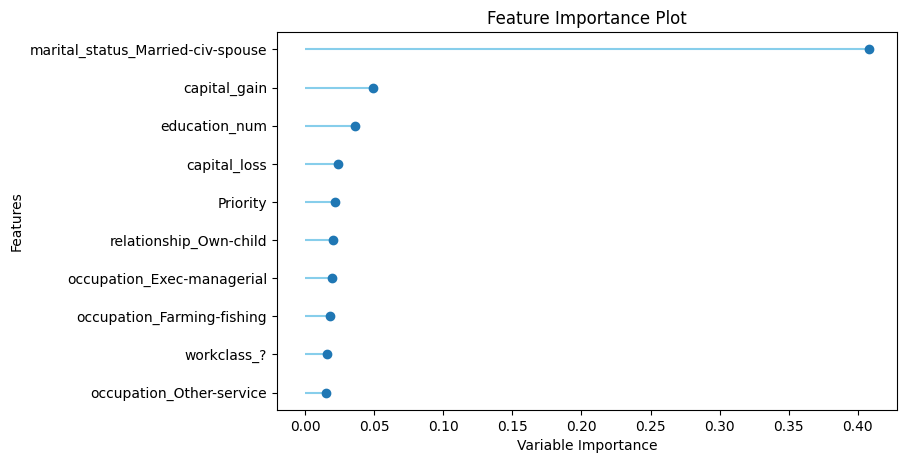

In [21]:
plot_model(estimator = xgboost, plot = 'feature')

In [22]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8684,0.9234,0.6375,0.7787,0.7011,0.6178,0.6229
1,0.8637,0.9170,0.6634,0.7455,0.7021,0.6141,0.6159
2,0.8614,0.9171,0.6570,0.7409,0.6964,0.6070,0.6089
3,0.8566,0.9133,0.6201,0.7432,0.6761,0.5850,0.5889
4,0.8597,0.9085,0.6278,0.7519,0.6843,0.5951,0.5991
5,0.8699,0.9303,0.6602,0.7698,0.7108,0.6275,0.6306
6,0.8715,0.9330,0.6311,0.7959,0.7040,0.6233,0.6301
7,0.8597,0.9204,0.6311,0.7500,0.6854,0.5960,0.5997
8,0.8668,0.9230,0.6375,0.7725,0.6986,0.6141,0.6187
9,0.8762,0.9215,0.6893,0.7745,0.7295,0.6495,0.6514


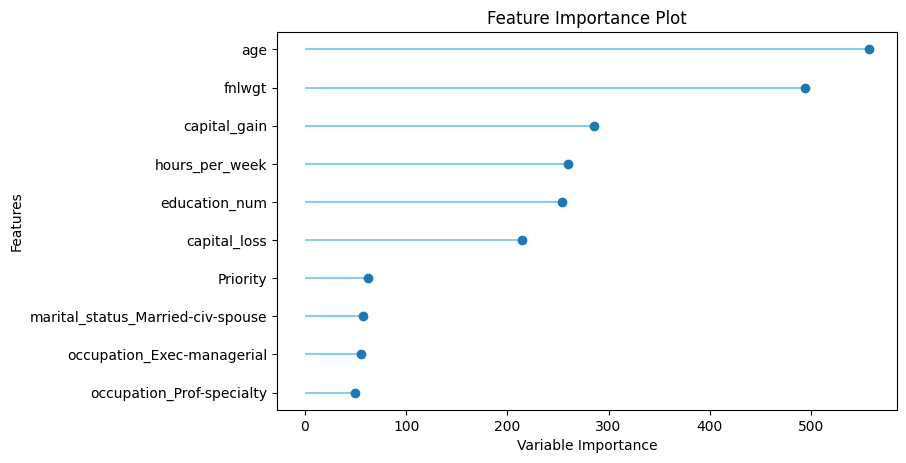

In [23]:
plot_model(estimator = lightgbm, plot = 'feature')